<a href="https://colab.research.google.com/github/PosgradoMNA/Proyecto_A01794099/blob/main/Avance1_Equipo12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

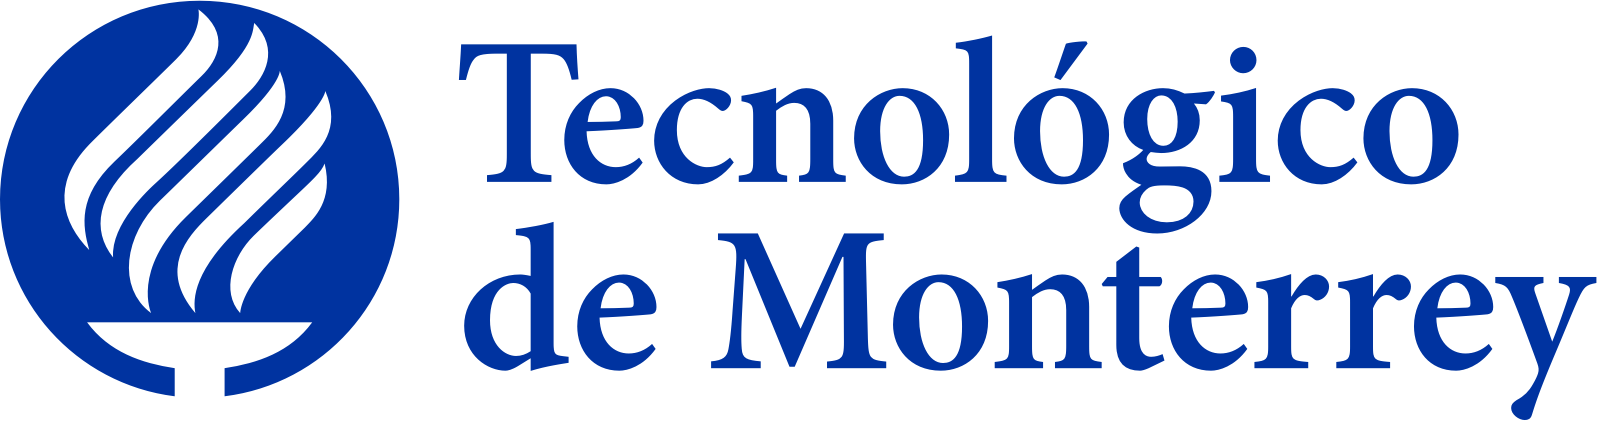

# Maestría en Inteligencia Artificial Aplicada
## Tecnológico de Monterrey
## TC5035.10 – Proyecto Integrador

### Avance 1 - Análisis exploratorio de datos: Reconocimiento robusto de comandos de voz en robots mediante paráfrasis y clasificación k-NN

**Profesores titulares: Dra. Grettel Barceló Alonso, Dr. Luis Eduardo Falcón Morales**

**Profesor asistente: Mtra. Verónica Sandra Guzmán de Valle**


**Equipo 12:**
*   Laura Irán González Ojeda - **A01794099**


# Exploratory Data Analysis (EDA) para un Modelo de Clasificación de Comandos

## Contexto del Dataset

Este dataset fue diseñado para desarrollar un modelo de clasificación de comandos de voz que pueda predecir acciones específicas asociadas con un robot. Originalmente, el conjunto de datos brindado por la compañía solo contenía la columna **'action'**, que describe las acciones que el robot debe realizar, como mover el brazo, girar o sujetar objetos. Posteriormente, se añadió la columna **'command'**, que contiene frases alternativas que los usuarios podrían utilizar para describir cada acción.

Además, se introdujo una clase adicional denominada **'no_command'** para representar comandos irrelevantes o no relacionados con las acciones del robot, tales como "Play a song" o "Set an alarm". Esta clase ayuda al modelo a diferenciar entre comandos válidos para el robot y otros comandos irrelevantes.

El objetivo de este análisis es entender mejor la estructura del dataset y aplicar técnicas de preprocesamiento que preparen los datos para entrenar un modelo de aprendizaje automático que pueda clasificar correctamente las acciones basadas en diferentes variaciones de comandos. El análisis incluye la revisión de valores faltantes, outliers, cardinalidad de variables categóricas, y la distribución de las clases.


In [ ]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

# Cargar el dataset

file_path = r'C:\Users\ligonzal\OneDrive - Intel Corporation\Documents\GitHub\applications.ai.cobot\data\commands.csv'

data = pd.read_csv(file_path)

# Visualizar las primeras filas del dataset
data.head()


,command,action
0,Move the arm to the left,move_left
1,Make the arm move to the left,move_left
2,Move the arm to the right,move_right
3,Make the arm move to the right,move_right
4,Move the arm up,move_up


#### 1. Identificación de valores faltantes

Es importante revisar si hay valores faltantes en el conjunto de datos para decidir cómo tratarlos. La ausencia de datos puede afectar la precisión de los modelos, por lo que es esencial realizar un manejo adecuado de estos valores.


In [ ]:
# 1. Identificación de valores faltantes
missing_values = data.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)


Valores faltantes por columna:
 command    0
action     0
dtype: int64


#### 2. Estadísticas Resumidas

Revisar las estadísticas descriptivas básicas del conjunto de datos nos ayudará a entender las propiedades de las variables, como su distribución y los valores más comunes.


In [ ]:
# 2. Estadísticas resumidas del dataset
print("\nEstadísticas de las variables categóricas:")
print(data.describe(include=['object']))

# Distribución de la columna 'action'
print("\nDistribución de la columna 'action':")
print(data['action'].value_counts())

# Distribución de la columna 'command'
print("\nDistribución de la columna 'command':")
print(data['command'].value_counts())



Estadísticas de las variables categóricas:
                         command      action
count                         50          50
unique                        50          21
top     Move the arm to the left  no_command
freq                           1          10

Distribución de la columna 'action':
action
no_command                 10
place_on_conveyor           2
shut_down                   2
check_malfunctions          2
move_to_next                2
signal_technician           2
verify_position             2
adjust_position             2
tighten_bolts               2
screw_in_place              2
move_left                   2
move_right                  2
close_gripper               2
open_gripper                2
retract                     2
extend                      2
rotate_counterclockwise     2
rotate_clockwise            2
move_down                   2
move_up                     2
pick_up                     2
Name: count, dtype: int64

Distribución de la columna 'c

In [ ]:
# Longitud promedio de comandos
data['command_length'] = data['command'].apply(len)
avg_length = data['command_length'].mean()
print(f'Longitud promedio de comandos: {avg_length}')

Longitud promedio de comandos: 23.58


#### 3. Visualización de la distribución de la columna 'action'

Para entender mejor cómo se distribuyen las acciones, realizamos una visualización de las diferentes categorías de la variable 'action'.


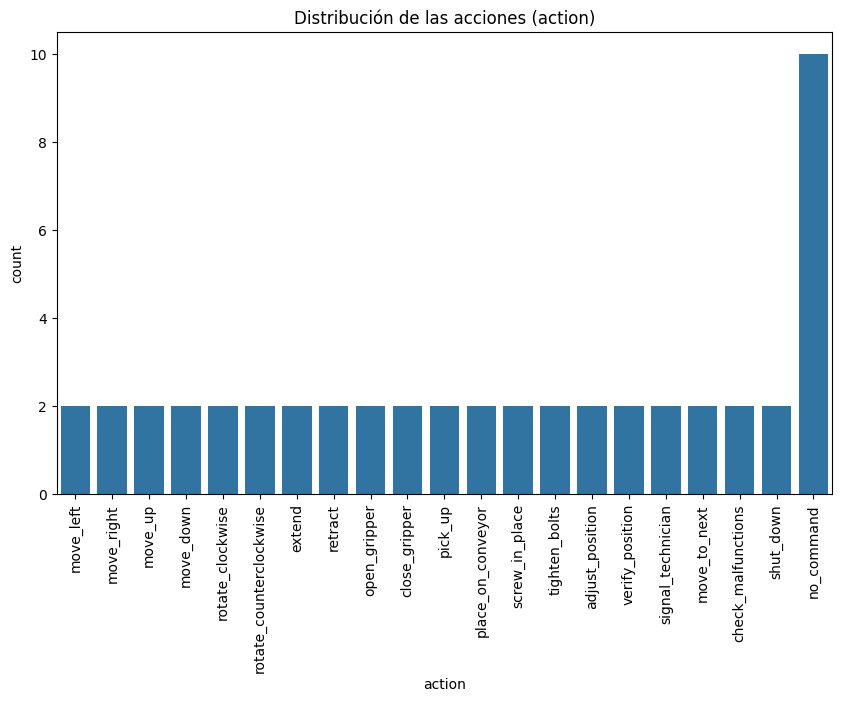

In [ ]:
# 3. Visualización de la distribución de 'action'
plt.figure(figsize=(10,6))
sns.countplot(x='action', data=data)
plt.xticks(rotation=90)
plt.title('Distribución de las acciones (action)')
plt.show()


#### 4. Identificación de Valores Atípicos

Los valores atípicos o poco comunes pueden influir en la precisión del modelo. Aquí revisamos si hay comandos que se presentan con muy poca frecuencia.


In [ ]:
# 4. Identificación de valores atípicos (comandos raros)
print("\nComandos menos frecuentes:")
rare_commands = data['command'].value_counts().tail(5)
print(rare_commands)



Comandos menos frecuentes:
command
Clamp the gripper shut                   1
Pick up the object                       1
Grab the object                          1
Place the object on the assembly line    1
Send an email                            1
Name: count, dtype: int64


#### 5. Cardinalidad de las Variables Categóricas

La cardinalidad de una variable categórica se refiere a la cantidad de valores únicos que contiene. Entender esto nos ayuda a conocer la diversidad de datos y si podría ser útil reducir las categorías.


In [ ]:
# 5. Cardinalidad de las variables categóricas
unique_commands = data['command'].nunique()
unique_actions = data['action'].nunique()
print(f"\nNúmero de comandos únicos: {unique_commands}")
print(f"Número de acciones únicas: {unique_actions}")



Número de comandos únicos: 50
Número de acciones únicas: 21


#### 6.  Análisis de Frecuencia de Comandos y Acciones
Al agrupar comandos con significados similares, podemos ayudar al modelo a generalizar mejor. Usamos codificación de etiquetas para representar las acciones en forma numérica.


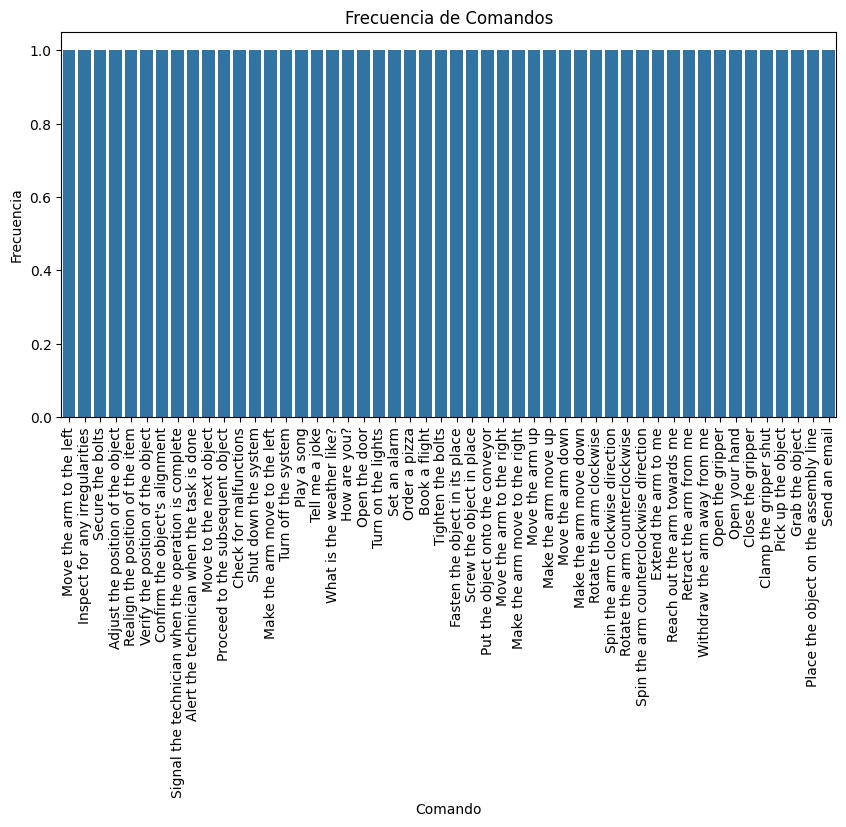

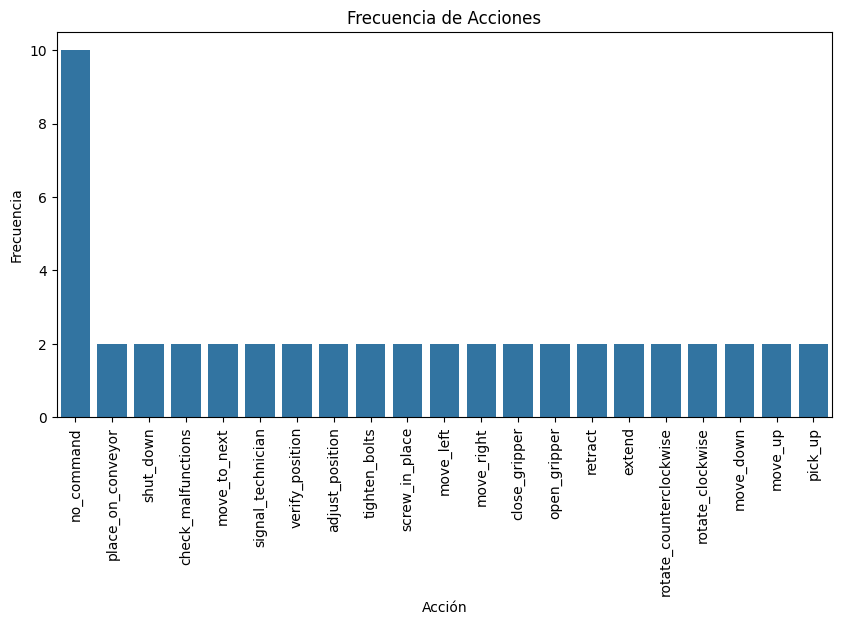

In [ ]:
# Frecuencia de comandos
command_counts = data['command'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=command_counts.index, y=command_counts.values)
plt.xticks(rotation=90)
plt.title('Frecuencia de Comandos')
plt.xlabel('Comando')
plt.ylabel('Frecuencia')
plt.show()

# Frecuencia de acciones
action_counts = data['action'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=action_counts.index, y=action_counts.values)
plt.xticks(rotation=90)
plt.title('Frecuencia de Acciones')
plt.xlabel('Acción')
plt.ylabel('Frecuencia')
plt.show()



#### 7. Análisis de Relaciones



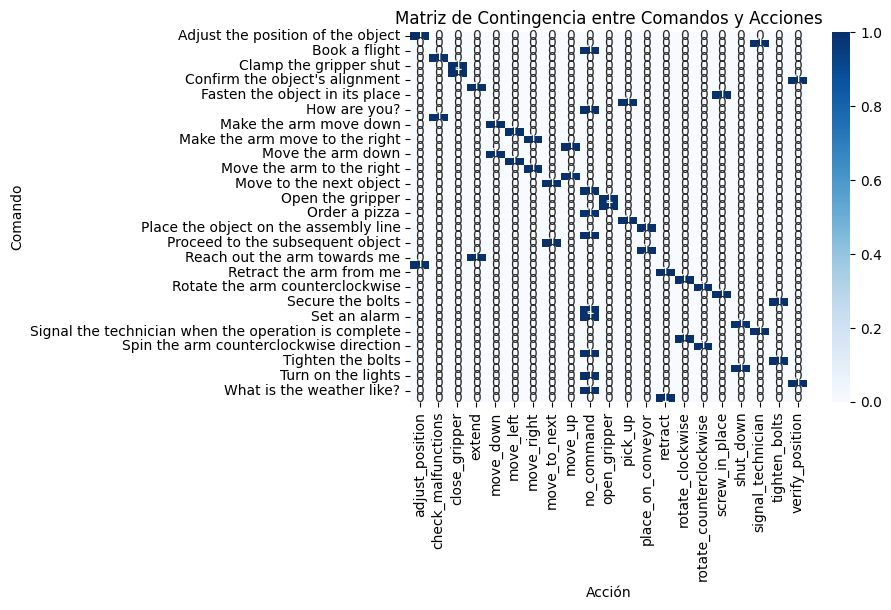

In [ ]:
# Crear matriz de contingencia
contingency_table = pd.crosstab(data['command'], data['action'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Contingencia entre Comandos y Acciones')
plt.xlabel('Acción')
plt.ylabel('Comando')
plt.show()
